In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import colorcet as cc
import matplotlib.cm as cm
import os
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")
import sys
sys.path.append("../SpikeCounter")
sys.path.append("../ephysSimsPython")
from spikecounter import utils
import pandas as pd
import seaborn as sns
import pickle
import shutil
from scipy import stats
import importlib

In [2]:
def reload_libraries():
    importlib.reload(utils)

In [3]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20221103_pde_v4/"
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures"

In [4]:
def process_stats(df, subfolder):
    df["mean_origin_pos"] = np.nan
    df["frac_25"] = np.nan
    df["origin_entropy"] = np.nan
    df["mean_area"] = np.nan
    df["frac_full_area"] = np.nan
    df["mean_isi"] = np.nan
    df["std_isi"] = np.nan
    df["cv_isi"] = np.nan
    df["phase_drift_rate"] = np.nan
    df["phase_variance"] = np.nan
    df["crossings_per_cycle"] = np.nan
    df["var_origin_pos"] = np.nan
    for idx in range(df.shape[0]):
        row = df.iloc[idx]
        measurements = np.load(os.path.join(rootdir, subfolder, row["sim_id"], "stats.npz"))
        wave_origins = measurements["all_wave_origins"]
        areas = measurements["all_areas"]
        df["mean_origin_pos"].iat[idx] = np.nanmean(wave_origins)
        df["var_origin_pos"].iat[idx] = np.nanvar(wave_origins)

        df["frac_25"].iat[idx] = np.nansum(wave_origins==24)/len(wave_origins)
        df["origin_entropy"].iat[idx] = stats.entropy(wave_origins[np.isfinite(wave_origins)], base=2)
        df["mean_area"].iat[idx] = np.nanmean(areas)
        df["frac_full_area"].iat[idx] = np.nansum(areas==25)/len(areas)
        df["mean_isi"].iat[idx] = np.nanmean(measurements["mean_isi"])
        df["std_isi"].iat[idx] = np.nanmean(measurements["std_isi"])
        df["cv_isi"].iat[idx] = np.nanmean(measurements["std_isi"]/measurements["mean_isi"])
        
        phase_diff = np.squeeze(measurements["phase_diff"])
        drift_rates = []
        phase_variance = []
        
        dt = 0.1
        x = np.arange(phase_diff.shape[0])*dt
        
        mod_zero_centered = np.mod(phase_diff[x>100], np.pi*2)
        mod_zero_centered[mod_zero_centered > np.pi] = mod_zero_centered[mod_zero_centered > np.pi] - np.pi*2
        mean_zero_centered = np.mean(mod_zero_centered, axis=0)
        mod_mean_centered = np.mod(mod_zero_centered - mean_zero_centered, np.pi*2)
        mod_mean_centered[mod_mean_centered > np.pi] = mod_mean_centered[mod_mean_centered > np.pi] - np.pi*2
        phase_variance.append(np.nanvar(mod_mean_centered, axis=0))
        

        for i in range(phase_diff.shape[1]):
            fit = stats.linregress(x, phase_diff[:,i])
            drift_rates.append(fit.slope)

        all_wave_timings = measurements["all_wave_timings"]
        if row["duration"] > 10000:
            all_wave_timings = all_wave_timings-40000
        all_wave_timings = all_wave_timings[all_wave_timings>100]
        if len(all_wave_timings) >= 3:

            wave_timing_indices = np.round(all_wave_timings*10).astype(int)
            per_wave_phase_diff = []
            kept_indices = [wave_timing_indices[0]]
            for i in range(1, len(wave_timing_indices)):
            #     windowed_diffs = np.mod(phase_diff[wave_timing_indices[i-1]:wave_timing_indices[i]], np.pi*2)
            #     windowed_diffs[windowed_diffs >= np.pi]
                windowed_diffs = phase_diff[kept_indices[-1]:wave_timing_indices[i]]

                if windowed_diffs.shape[0] > 10:
                    kept_indices.append(wave_timing_indices[i])
                    avg_phase_diff = np.mod(np.mean(windowed_diffs, axis=0), np.pi*2)
                    per_wave_phase_diff.append(avg_phase_diff)
            if len(per_wave_phase_diff) > 1:
                per_wave_phase_diff = np.array(per_wave_phase_diff)

                crossings = (np.diff(np.sign(np.diff(per_wave_phase_diff, axis=1)), axis=0)) !=0

                df["phase_drift_rate"].iat[idx] = np.nanmean(np.abs(drift_rates))
                df["phase_variance"].iat[idx] = np.nanmean(phase_variance)
                df["crossings_per_cycle"].iat[idx] = np.nansum(crossings)/len(kept_indices)

        
        
    df["freq"] = 1/df["mean_isi"]
    return df

In [5]:
subfolders = ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]
bifs = ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]

In [6]:
def load_data(subfolder):
    hashtable = set()
    data = []
    bif_dir = os.path.join(rootdir, subfolder)
    for sim in os.listdir(bif_dir):
#         print(sim)
        sim_dir = os.path.join(bif_dir, sim)
        if os.path.isdir(sim_dir):
            try:
                with open(os.path.join(sim_dir, "params.pickle"), "rb") as pckl:
                    
                    params = pickle.load(pckl)
                    measurements = np.load(os.path.join(sim_dir, "stats.npz"))
                    if np.any(np.isfinite(measurements["mean_isi"])):
                        entry = (params["bif"], float(utils.round_rel_deviation(params["D"])),\
                                 float(utils.round_rel_deviation(params["sigma"])),\
                                 float(utils.round_rel_deviation(params["I_mean"])),\
                                 float(utils.round_rel_deviation(params["I_std"])), \
                                 float(utils.round_rel_deviation(params["I_height"])),\
                                     params["I_intercept"], params["n_y"], params["duration"])
                        h = hash(str(entry))
                        if h not in hashtable:
                            data.append(entry + (sim,))
                            hashtable.add(h)
#                     else:
#                         shutil.rmtree(sim_dir)

            except Exception as e:
#                 raise(e)
                print(e)
#                 shutil.rmtree(sim_dir)
                continue
    df = pd.DataFrame(data, columns=["bifurcation", "D", "sigma", "I_mean",\
            "I_std", "I_height", "I_intercept", "n_cells", "duration", "sim_id"])
    df = df.set_index("bifurcation")
    return df

In [24]:
list(enumerate(subfolders))

[(0, 'snic'),
 (1, 'saddle_node'),
 (2, 'supercritical_hopf'),
 (3, 'subcritical_hopf')]

In [7]:
subfolders = []
dfs = {}
subfolders = ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]
bifs = ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]


In [ ]:
for idx, subfolder in list(enumerate(subfolders)):
    dfs[bifs[idx]] = process_stats(load_data(subfolder).sort_values(["D", "sigma", "I_height"]), subfolder)
    dfs[bifs[idx]].reset_index().to_csv(os.path.join(rootdir, subfolder, "all_simulation_stats.csv"), index=False)

File is not a zip file


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [7]:
def plot_heatmap(df, column, ax, norm="lin", cax="auto"):
    pv = pd.pivot_table(df, index=["D"], columns=["sigma"], values=column)
    Z = pv.to_numpy()
    if norm == "log":
        norm = mpl.colors.LogNorm(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    elif norm == "lin":
        norm = mpl.colors.Normalize(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    elif norm is None:
        norm = mpl.colors.Normalize(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    im = ax.pcolormesh(pv.columns, pv.index, Z,\
                norm=norm)
    ax.set_xscale("log")
    ax.set_yscale("log")
#     ax.set_xlabel(r"$\sigma$")
#     ax.set_ylabel(r"$D$")
    cbar = None
    if cax =="auto":
        cbar = plt.colorbar(im, ax=ax)
    elif cax is not None:
        cbar = plt.colorbar(im, cax=cax)
    return ax, im, cbar

In [8]:
dfs = {}
for idx, subfolder in enumerate(subfolders):
    dfs[bifs[idx]] = pd.read_csv(os.path.join(rootdir, subfolder, "all_simulation_stats.csv"))

In [9]:
dfs_single = pd.concat(dfs.values(), axis=0)


In [10]:
bifurcations = ["saddle_node", "snic", "supercritical_hopf", "subcritical_hopf"]
titles = ["Saddle-node", "SNIC", "Supercritical Hopf", "Subcritical Hopf"]

Text(0.48, 0.065, '$\\sigma_w$')

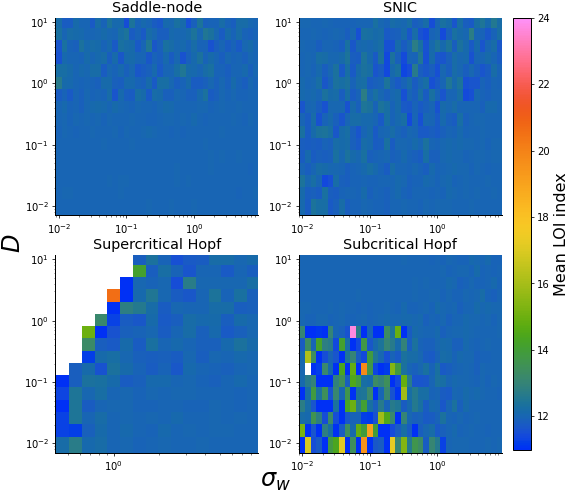

In [13]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
    norm = mpl.colors.Normalize(vmin=11,vmax=24)
    df_by_slope = dfs[bif].set_index("I_std").loc[0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[0]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean LOI index")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=None)
    ax.set_title(titles[idx])
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_loi_no_heterogeneity.tif"), dpi=600)

Text(0.48, 0.065, '$\\sigma_w$')

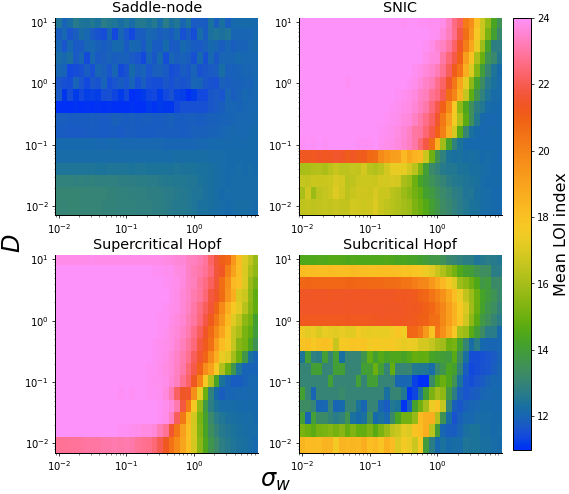

In [12]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
    norm = mpl.colors.Normalize(vmin=11,vmax=24)
    df_by_slope = dfs[bif].set_index("I_std").loc[0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[-1]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean LOI index")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=None)
    ax.set_title(titles[idx])
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_loi_no_heterogeneity.tif"), dpi=600)

Text(0.48, 0.065, '$\\sigma_w$')

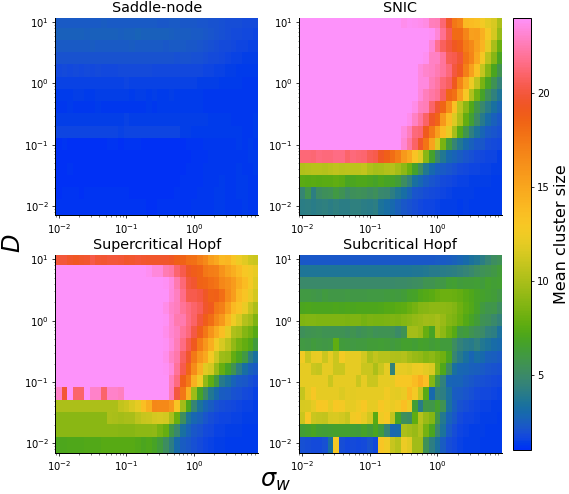

In [13]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
    norm = mpl.colors.Normalize(vmin=1,vmax=24)
    df_by_slope = dfs[bif].set_index("I_std").loc[0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[-1]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_area", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean cluster size")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_area", axes[idx], norm=norm, cax=None)
    ax.set_title(titles[idx])
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_cluster_size_no_heterogeneity.tif"), dpi=600)

Text(0.48, 0.065, '$\\sigma_w$')

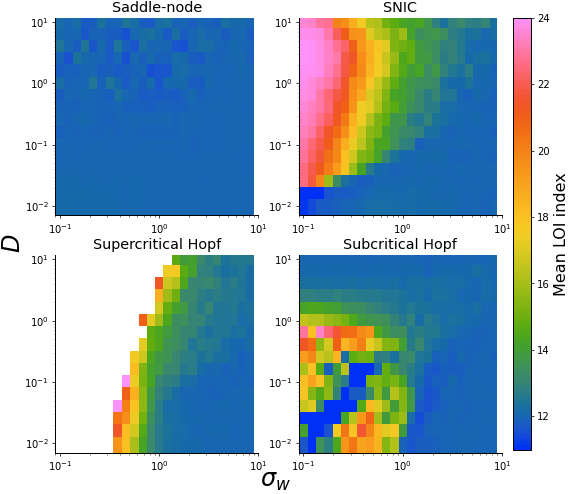

In [14]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
    norm = mpl.colors.Normalize(vmin=11,vmax=24)
    df_by_slope = dfs[bif].set_index("I_std").loc[0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[1]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean LOI index")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=None)
    ax.set_title(titles[idx])
    ax.set_xlim(0.09, 10)
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_loi_no_heterogeneity.tif"), dpi=600)

Text(0.48, -0.15, '$\\sigma_w$')

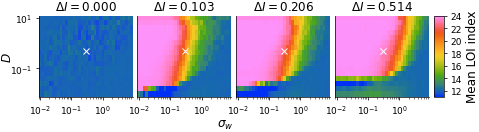

In [14]:
plt.close("all")
norm = mpl.colors.Normalize(vmin=11,vmax=24)
df_by_slope = dfs["snic"].set_index("I_std").loc[0].set_index("I_height")
fig1, axes = plt.subplots(1,4, figsize=(7,1.5))
axes = axes.ravel()
plt.subplots_adjust(wspace=0.05)
for idx, height in enumerate(df_by_slope.index.unique()[:-1]):
    slope_df = df_by_slope.loc[height]
    if idx == 0:
        cax = plt.axes([0.91, 0.13, 0.02, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean LOI index", fontsize=12)
        cbar.ax.set_yticks([12,14,16,18,20,22,24])
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=None)
        ax.get_yaxis().set_visible(False)
    ax.plot(0.3, 0.5, "wx")
    ax.set_title(r"$\Delta I = %.3f$" % height)
fig1.text(0.05, 0.48, r"$D$", rotation=90, fontsize=12)
fig1.text(0.48, -0.15, r"$\sigma_w$", fontsize=12)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "snic_mean_LOI_idx.tif"), dpi=600)

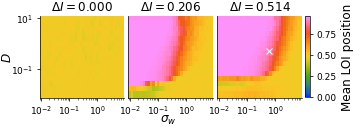

In [29]:
plt.close("all")
# norm = None
df_by_slope = dfs["snic"].set_index("I_std").loc[0].set_index("I_height")
df_by_slope["norm_mean_pos"] = df_by_slope["mean_origin_pos"]/25
norm = mpl.colors.Normalize(vmin=0,vmax=np.nanmax(df_by_slope["norm_mean_pos"]))
fig1, axes = plt.subplots(1,3, figsize=(4.7,1.5))
axes = axes.ravel()
plt.subplots_adjust(wspace=0.05)
for idx, height in enumerate(df_by_slope.index.unique()[[0,2,3]]):
    slope_df = df_by_slope.loc[height]
    if idx == 0:
        cax = plt.axes([0.91, 0.13, 0.015, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "norm_mean_pos", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean LOI position", fontsize=12)
#         cbar.ax.set_yticks([0,5,10])
    else:
        ax, im, cbar = plot_heatmap(slope_df, "norm_mean_pos", axes[idx], norm=norm, cax=None)
        ax.get_yaxis().set_visible(False)
    ax.set_title(r"$\Delta I = %.3f$" % height)
axes[2].plot(0.618, 0.5, "wx")
fig1.text(0.01, 0.48, r"$D$", rotation=90, fontsize=12)
fig1.text(0.48, -0.1, r"$\sigma_w$", fontsize=12)
plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "snic_mean_LOI_idx.tif"), dpi=600)

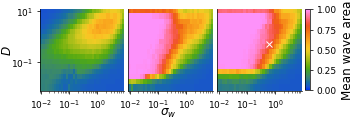

In [28]:
plt.close("all")
# norm = None
df_by_slope = dfs["snic"].set_index("I_std").loc[0].set_index("I_height")
df_by_slope["norm_area"] = df_by_slope["mean_area"]/25
norm = mpl.colors.Normalize(vmin=0,vmax=np.nanmax(df_by_slope["norm_area"]))
fig1, axes = plt.subplots(1,3, figsize=(4.7,1.5))
axes = axes.ravel()
plt.subplots_adjust(wspace=0.05)
for idx, height in enumerate(df_by_slope.index.unique()[[0,2,3]]):
    slope_df = df_by_slope.loc[height]
    if idx == 0:
        cax = plt.axes([0.91, 0.13, 0.015, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "norm_area", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean wave area", fontsize=12)
#         cbar.ax.set_yticks([0,5,10])
    else:
        ax, im, cbar = plot_heatmap(slope_df, "norm_area", axes[idx], norm=norm, cax=None)
        ax.get_yaxis().set_visible(False)
#     ax.set_title(r"$\Delta I = %.3f$" % height)
axes[2].plot(0.618, 0.5, "wx")
fig1.text(0.01, 0.48, r"$D$", rotation=90, fontsize=12)
fig1.text(0.48, -0.1, r"$\sigma_w$", fontsize=12)
plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "snic_mean_cluster_size.tif"), dpi=600)

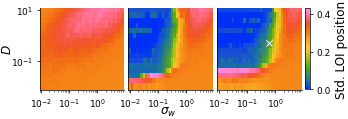

In [26]:
plt.close("all")
# norm = None
df_by_slope = dfs["snic"].set_index("I_std").loc[0].set_index("I_height")
df_by_slope["std_origin_pos"] = np.sqrt(df_by_slope["var_origin_pos"])/25
norm = mpl.colors.Normalize(vmin=0,vmax=np.nanmax(df_by_slope["std_origin_pos"]))
fig1, axes = plt.subplots(1,3, figsize=(4.7,1.5))
axes = axes.ravel()
plt.subplots_adjust(wspace=0.05)
for idx, height in enumerate(df_by_slope.index.unique()[[0,2,3]]):
    slope_df = df_by_slope.loc[height]
    if idx == 0:
        cax = plt.axes([0.91, 0.13, 0.015, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "std_origin_pos", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Std. LOI position", fontsize=12)
#         cbar.ax.set_yticks([0,5,10])
    else:
        ax, im, cbar = plot_heatmap(slope_df, "std_origin_pos", axes[idx], norm=norm, cax=None)
        ax.get_yaxis().set_visible(False)
#     ax.set_title(r"$\Delta I = %.3f$" % height)
axes[2].plot(0.618, 0.5, "wx")
fig1.text(0.01, 0.48, r"$D$", rotation=90, fontsize=12)
fig1.text(0.48, -0.1, r"$\sigma_w$", fontsize=12)
plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "std_var_LOI_idx.tif"), dpi=600)

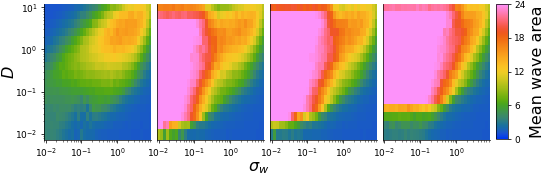

In [14]:
plt.close("all")
norm = mpl.colors.Normalize(vmin=0,vmax=24)
df_by_slope = dfs["snic"].set_index("I_std").loc[0].set_index("I_height")
fig1, axes = plt.subplots(1,4, figsize=(8,2.5))
axes = axes.ravel()
plt.subplots_adjust(wspace=0.05)
for idx, height in enumerate(df_by_slope.index.unique()[:-1]):
    slope_df = df_by_slope.loc[height]
    if idx == 0:
        cax = plt.axes([0.91, 0.13, 0.02, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_area", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean wave area", fontsize=16)
        cbar.ax.set_yticks([0, 6, 12, 18, 24])
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_area", axes[idx], norm=norm, cax=None)
        ax.get_yaxis().set_visible(False)
    # ax.set_title(r"$\Delta I = %.3f$" % height)
fig1.text(0.05, 0.48, r"$D$", rotation=90, fontsize=16)
fig1.text(0.48, -0.05, r"$\sigma_w$", fontsize=16)
plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "snic_mean_cluster_size.tif"), dpi=600)

In [14]:
bifurcations = ["saddle_node", "snic", "supercritical_hopf", "subcritical_hopf"]
titles = ["Saddle-node", "SNIC", "Supercritical Hopf", "Subcritical Hopf"]

Text(0.48, 0.065, '$\\sigma_w$')

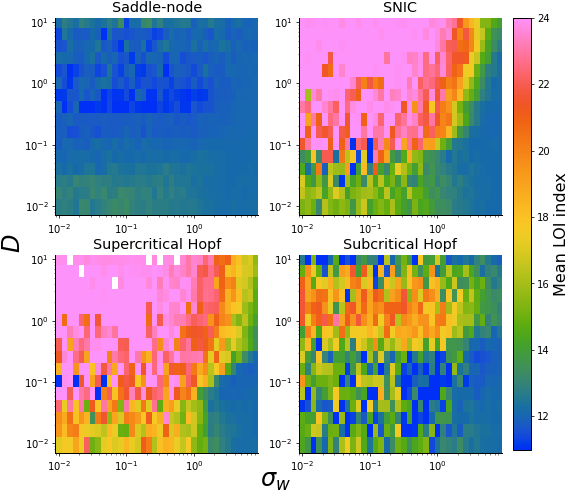

In [14]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
    norm = mpl.colors.Normalize(vmin=11,vmax=24)
    df_by_slope = dfs[bif].set_index("I_std")
    df_by_slope = df_by_slope[df_by_slope.index !=0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[-1]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean LOI index")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_origin_pos", axes[idx], norm=norm, cax=None)
    ax.set_title(titles[idx])
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_loi_heterogeneity.tif"), dpi=600)

Text(0.48, 0.065, '$\\sigma_w$')

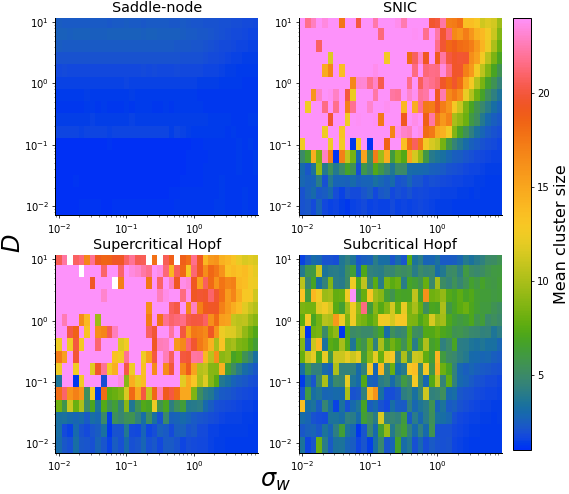

In [15]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
    norm = mpl.colors.Normalize(vmin=1,vmax=24)
    df_by_slope = dfs[bif].set_index("I_std")
    df_by_slope = df_by_slope[df_by_slope.index !=0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[-1]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "mean_area", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean cluster size")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "mean_area", axes[idx], norm=norm, cax=None)
    ax.set_title(titles[idx])
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_cluster_size_heterogeneity.tif"), dpi=600)

Text(0.48, 0.065, '$\\sigma_w$')

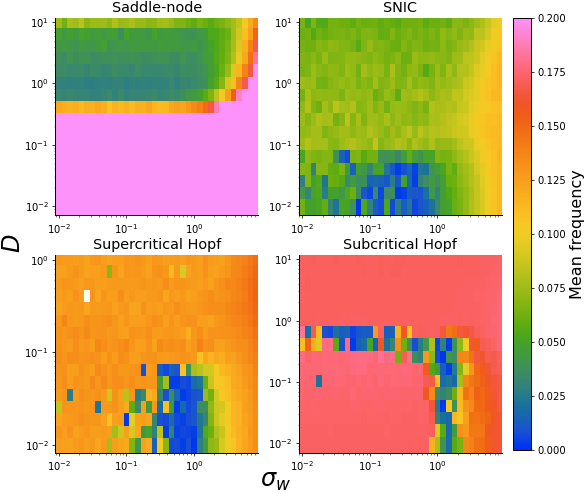

In [20]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
    norm = mpl.colors.Normalize(vmin=0,vmax=0.2)
#     norm = None
    df_by_slope = dfs[bif].set_index("I_std")
    df_by_slope = df_by_slope[df_by_slope.index !=0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[-1]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "freq", axes[idx], norm=norm, cax=cax)
        cbar.ax.set_ylabel("Mean frequency")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "freq", axes[idx], norm=norm, cax=None)
    ax.set_title(titles[idx])
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_cluster_size_heterogeneity.tif"), dpi=600)

Text(0.48, 0.065, '$\\sigma_w$')

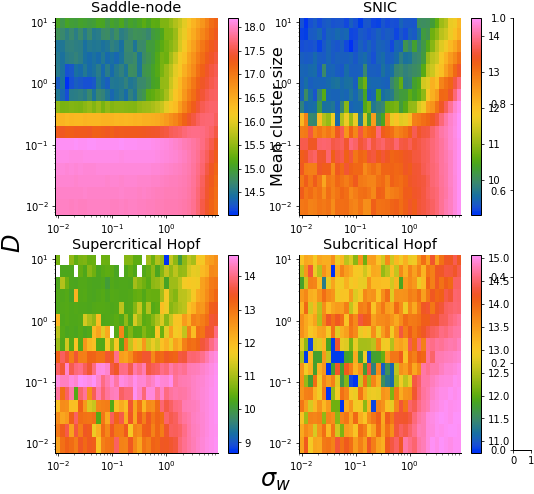

In [15]:
plt.close("all")
fig1, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.ravel()
for idx, bif in enumerate(bifurcations):
#     norm = mpl.colors.Normalize(vmin=1,vmax=24)
    norm = None
    df_by_slope = dfs[bif].set_index("I_std")
    df_by_slope = df_by_slope[df_by_slope.index !=0].set_index("I_height")
    slopes = sorted(df_by_slope.index.unique())
    slope_df = df_by_slope.loc[slopes[-1]]
    if idx == 0:
        cax = plt.axes([0.92, 0.13, 0.03, 0.75])
        ax, im, cbar = plot_heatmap(slope_df, "origin_entropy", axes[idx], norm=norm, cax="auto")
#         cbar.ax.set_ylabel("Mean cluster size")
    else:
        ax, im, cbar = plot_heatmap(slope_df, "origin_entropy", axes[idx], norm=norm, cax="auto")
    ax.set_title(titles[idx])
fig1.text(0.03, 0.48, r"$D$", rotation=90, fontsize=24)
fig1.text(0.48, 0.065, r"$\sigma_w$", fontsize=24)
# plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "mean_cluster_size_heterogeneity.tif"), dpi=600)

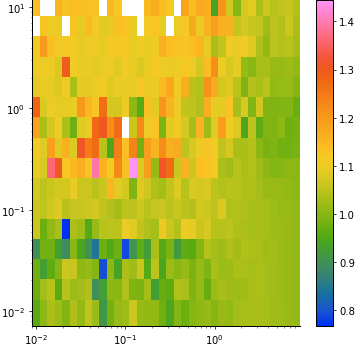

In [21]:
fig1, ax1 = plt.subplots(figsize=(6,6))
column = "origin_entropy"

df_by_slope = dfs["snic"].set_index("I_std")
df_by_slope = df_by_slope[df_by_slope.index !=0].set_index("I_height")
slopes = sorted(df_by_slope.index.unique())
slope_df = df_by_slope.loc[slopes[-1]]
pv_snic = pd.pivot_table(slope_df, index=["D"], columns=["sigma"], values=column)

df_by_slope = dfs["supercritical_hopf"].set_index("I_std")
df_by_slope = df_by_slope[df_by_slope.index !=0].set_index("I_height")
slopes = sorted(df_by_slope.index.unique())
slope_df = df_by_slope.loc[slopes[-1]]
pv_suph = pd.pivot_table(slope_df, index=["D"], columns=["sigma"], values=column)


Z = pv_suph.to_numpy()/pv_snic.to_numpy()
norm = mpl.colors.Normalize(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
im = ax1.pcolormesh(pv_suph.columns, pv_suph.index, Z,\
            norm=norm)
cbar = plt.colorbar(im, ax=ax1)

ax1.set_xscale("log")
ax1.set_yscale("log")